# Table of contents
1. [Introduction](#introduction)
2. [Import](#import)
3. [Data preprocessing](#preprocess)
    1. [Missing values](#subpreprocess)
4. [Correlation with dependent variable](#correlation_dependent)
5. [Feature engineering](#feature_engineering)
    1. [One-hot encoding](#one-hot)
6. [Importance of variables](#importance)
    1. [Correlation between variables with highest importance score](#correlation_importance)
    2. [Variables selection](#variables_selection)
7. [Scaling data](#scaling)
8. [Train-test split](#train_test)
9. [Base estimator - linear regression](#base_estimator)
10. [Xgboost](#xgboost)

## This is the introduction <a name="introduction"></a>
Some introduction text, formatted in heading 2 style

## Importing packages and data <a name="import"></a>
The second paragraph text

In [1]:
import pandas as pd
import numpy as np
import os
import scipy as sp
import matplotlib
matplotlib.use('Qt4Agg')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import warnings
%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)

Changing the fontisize for all graphs so that everything is (hopefully) clearly visible

In [50]:
font = {'size'   : 15}

matplotlib.rc('font', **font)

In [51]:
data_house = pd.read_csv('train.csv')

## Data preprocessing <a name="preprocess"></a>
The first paragraph text

### Missing values <a name="subpreprocess"></a>
This is a sub paragraph, formatted in heading 3 style

Check on the missing values

In [4]:
missing = data_house.isnull().sum().sort_values(ascending=False)
percent = data_house.isnull().sum()/data_house.isnull().count().sort_values(ascending=False)
data_missing = pd.concat([missing, percent], axis=1, keys=['Total', 'Percent']).sort_values(by='Total', ascending=False)
print(data_missing.head(6))

             Total   Percent
PoolQC        1453  0.995205
MiscFeature   1406  0.963014
Alley         1369  0.937671
Fence         1179  0.807534
FireplaceQu    690  0.472603
LotFrontage    259  0.177397


Plot missing variables in descending order, results are shown only for those variables that do possess some NaNs

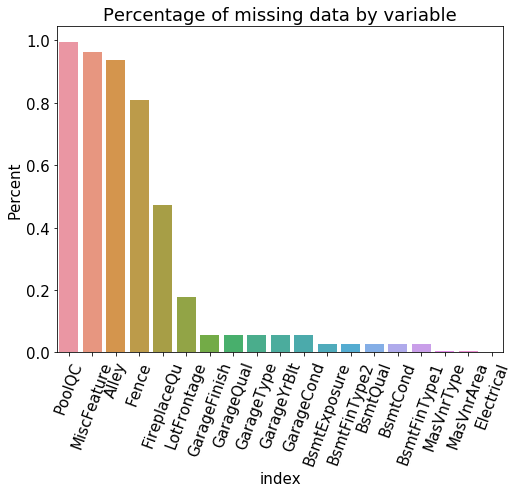

In [35]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,6))
sns.barplot(data=data_missing[data_missing['Percent'] >0].reset_index(), x = 'index', 
            y='Percent')
plt.xticks(rotation=70)
plt.title("Percentage of missing data by variable")
plt.show()

Drop variables when more than 90% of data is missing

In [6]:
data_house.drop(data_missing[data_missing['Percent']>0.7].index,1, inplace=True)

Based on description file.txt most of the missing data in variables such as Fence, Garage or Bsmt connected variables
are due to the lack of fence, garage etc. Due ot this fact we can fill NA in those variables with new category (since they are categorical variables)
For the data that is numeric the filled values are equal to zero - also due to the fact that apparent absence of values of these variables is connected with missing data

In [7]:
data_house.loc[:,data_house.columns.str.contains
("Garage|Bsmt|Fence|MasVnrType|Electrical|FireplaceQu")] =data_house.loc[:,
data_house.columns.str.contains("Garage|Bsmt|Fence|MasVnrType|Electrical|FireplaceQu")].fillna("MISSING")
data_house.loc[:,["MasVnrArea", "LotFrontage"]] = data_house.loc[:,["MasVnrArea", "LotFrontage"]].fillna(0)

Distribution of the target variable

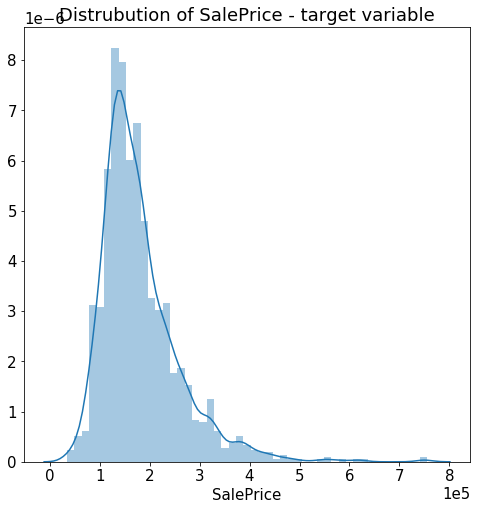

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


In [8]:
fig, ax = plt.subplots(figsize=(8,8))
sns.distplot(data_house['SalePrice'])
ax.set_title("Distrubution of SalePrice - target variable")
ax.ticklabel_format(style='scientific', axis='both', scilimits=(-3,3))
plt.show()
skew = data_house['SalePrice'].skew()
kurt = data_house['SalePrice'].kurt()
print(f'Skewness: {skew}\nKurtosis: {kurt}')

Fiew visualisations to show basic relationships and statistics

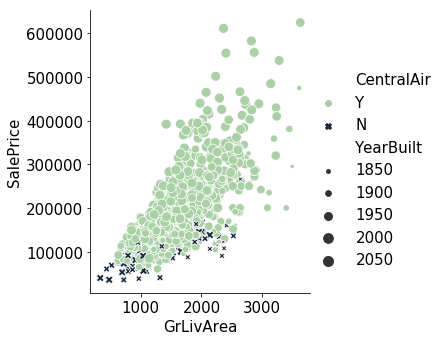

In [14]:
sns.relplot(x = 'GrLivArea', y = 'SalePrice', hue = 'CentralAir', style='CentralAir', 
            palette= "ch:r=-.5,l=0.75", size="YearBuilt", sizes=(15,100), data = data_house)
plt.show()

We can see that there are outliers present, with GrLivArea higher than 4000 square feet
<br>
They can be removed without further ado


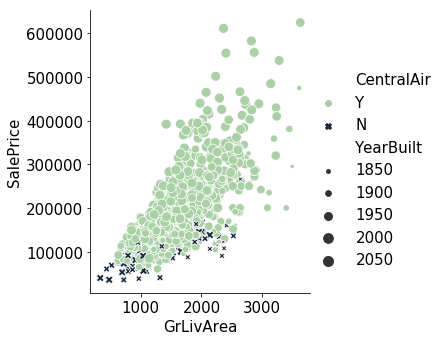

In [18]:
sns.relplot(x = 'GrLivArea', y = 'SalePrice', hue = 'CentralAir', style='CentralAir', 
            palette= "ch:r=-.5,l=0.75", size="YearBuilt", sizes=(15,100), data = data_house)
plt.show()

In [13]:
data_house = data_house[data_house['GrLivArea'] <4000]

Show average SalePrice by year

In [15]:
data_mean = data_house.groupby(by='YearBuilt').agg('mean')
data_mean.reset_index(inplace=True)

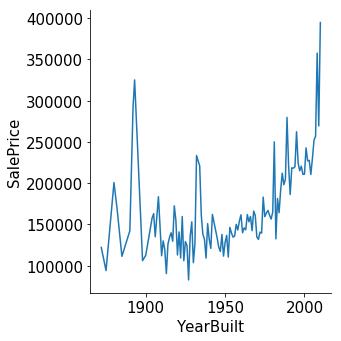

In [16]:
sns.relplot(x='YearBuilt', y = 'SalePrice', kind='line', data=data_mean)
plt.show()

Show the same data but this time with standard deviation

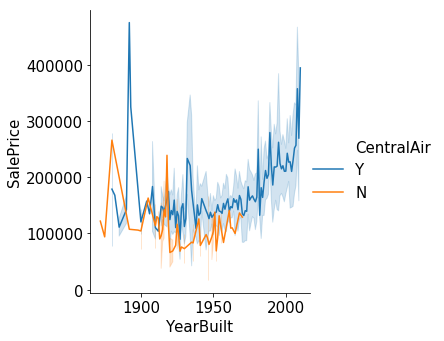

In [17]:
g = sns.relplot(x='YearBuilt', y = 'SalePrice', kind='line', ci='sd', estimator = 'mean',
            hue = 'CentralAir',data=data_house)
plt.show()

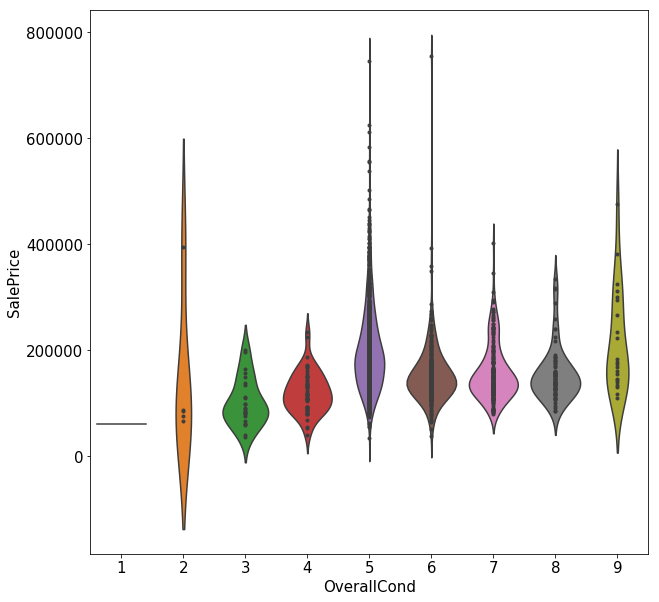

In [14]:
fig, ax = plt.subplots(figsize = (10,10))
sns.violinplot(data=data_house, y='SalePrice', x='OverallCond', ax=ax, inner='points')
plt.show()

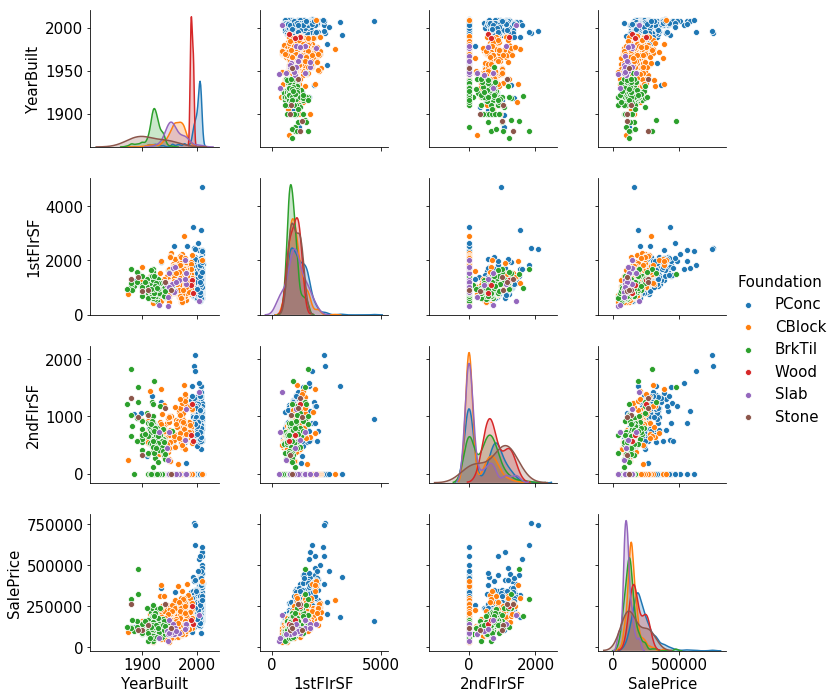

In [15]:
sns.pairplot(data=data_house, x_vars=['YearBuilt','1stFlrSF', '2ndFlrSF','SalePrice'],
             y_vars=['YearBuilt','1stFlrSF', '2ndFlrSF','SalePrice'], hue='Foundation')
plt.show()

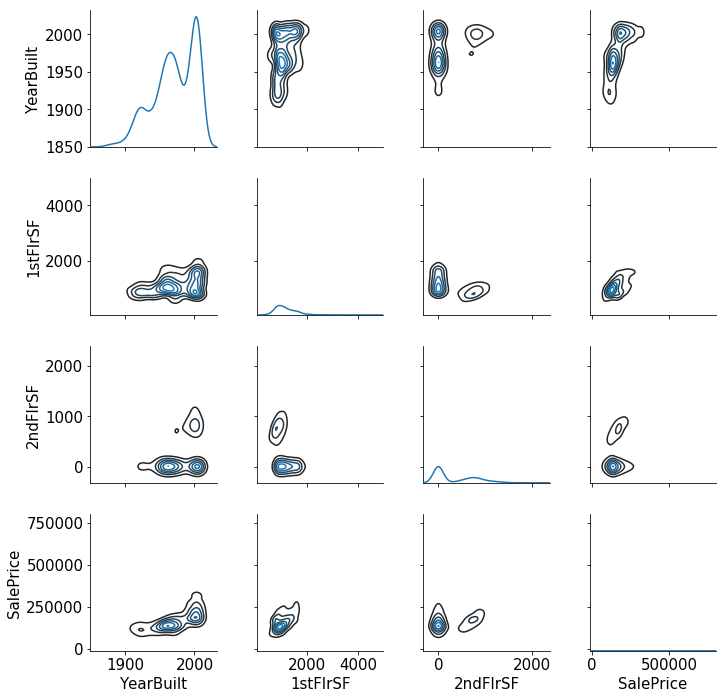

In [16]:
g = sns.PairGrid(data_house,x_vars=['YearBuilt','1stFlrSF', '2ndFlrSF','SalePrice'],
             y_vars=['YearBuilt','1stFlrSF', '2ndFlrSF','SalePrice'])
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6);

One can easily spot changes in the type of materials used to build houses throughout given time period.

Now it's time to check correlations between dependent variable and the rest

### Correlation with dependent variable <a name="correlation_dependent"></a>

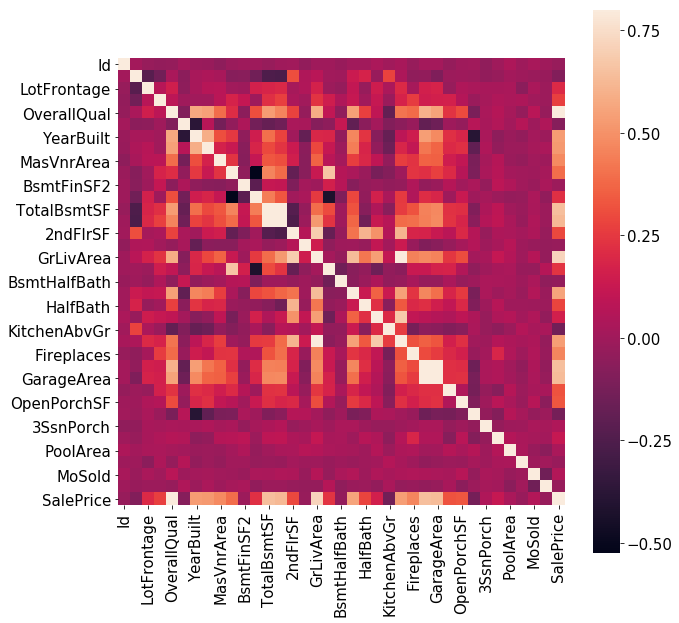

In [19]:
corrmat = data_house.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data=corrmat, vmax=.8, square=True)
plt.show()

Print only 10 mostly correlated variables

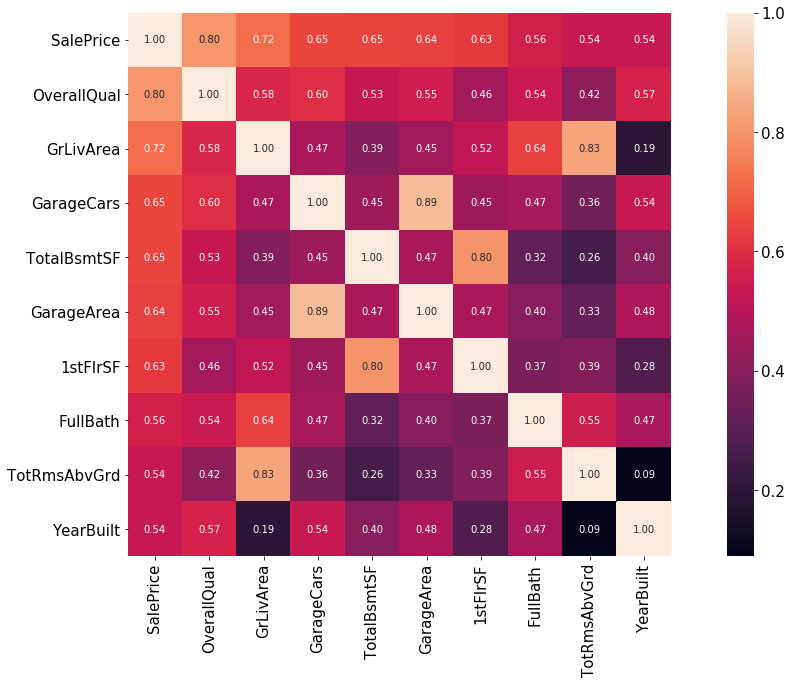

In [20]:
fig, ax = plt.subplots(figsize=(20,10))
cols = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
corr10 = data_house.loc[:, cols].corr()
sns.heatmap(data=corr10, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})
plt.show()

### Feature engineering <a name="feature_engineering"></a>

It's reasonable to define Age variable instead of YearBuilt, since during scaling year differences
<br>
would be insignificant compared to differences in house ages
<br>
since the newest records are from year 2010, I'm going to assume that the dataset is from 2011 and based on that 
calculate the Age variable

In [21]:
data_house['Age'] = 2011 - data_house['YearBuilt']

### One-hot encoding <a name="one-hot"></a>

One-hot encoding of the character variables
<br>
Semicolon added to surpress output

In [25]:
pd.get_dummies(data_house.select_dtypes('object'));
data_house_one_hot = pd.concat([data_house.select_dtypes(['int','float']),
                                pd.get_dummies(data_house.select_dtypes('object'))], axis=1)

### Importance of variables <a name="importance"></a>

Importance selection based on RandomForest result and one-hot encoded data

In [26]:
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=42)

In [27]:
X_rf = data_house_one_hot.columns.isin(["SalePrice","Id"])
rf.fit(X=data_house_one_hot.loc[:, ~X_rf], 
       y = data_house_one_hot.loc[:,"SalePrice"])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [29]:
importances = pd.concat([pd.Series(data_house_one_hot.columns[~X_rf]),
                         pd.Series(rf.feature_importances_)], axis=1)

In [207]:
importances_dict = dict(zip(data_house_one_hot.columns[~X_rf],rf.feature_importances_))

In [59]:
importances.columns = ['Feature', "Importance"]
importances_sorted = importances.sort_values(by="Importance",ascending=False)

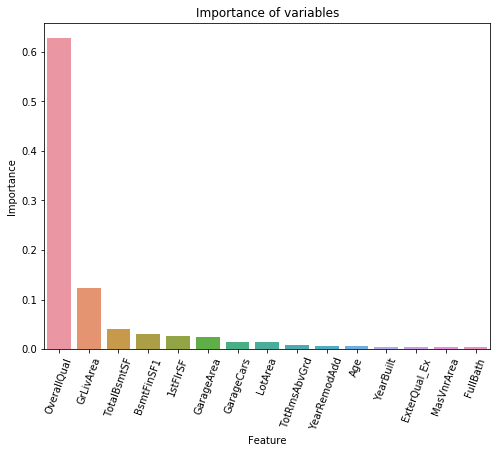

In [75]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,6))
sns.barplot(data=importances_sorted.iloc[:15,:],
            x = "Feature",
            y='Importance')
plt.xticks(rotation=70)
plt.title("Importance of variables")
plt.show()

Calculate correlation matrix between 15 variables with highest importance from randomforest

### Correlation between variables with highest importance score <a name="correlation_importance"></a>

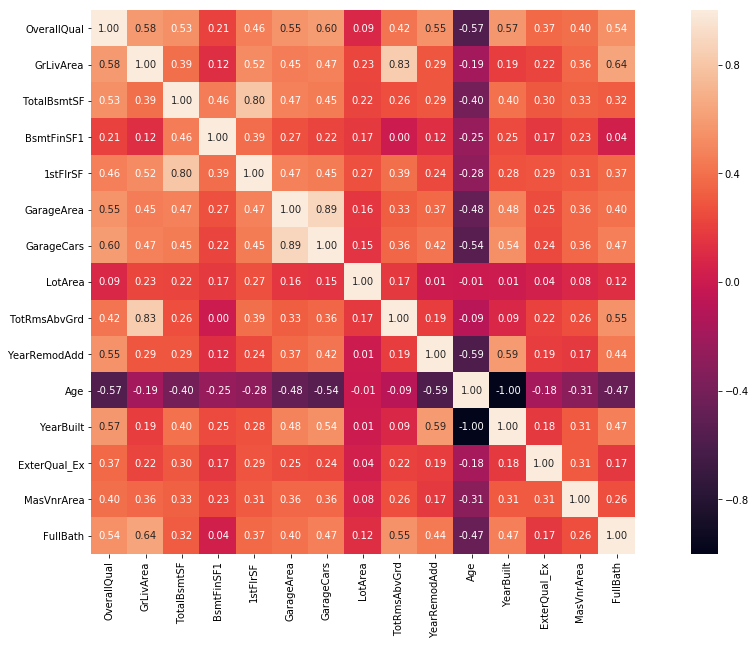

In [79]:
fig, ax = plt.subplots(figsize=(20,10))
correlations = data_house_one_hot.loc[:,importances_sorted.iloc[:15,:]['Feature']].corr()
sns.heatmap(correlations, annot=True, square=True,
           fmt='.2f', annot_kws = {'size': 10})

### Variables selection <a name="variables_selection"></a>

Select only pairs with higher correlation than threshold given in np.triu function

In [228]:
corr_matrix = correlations.abs()
index_names = corr_matrix.index
col_names = corr_matrix.columns
arr = corr_matrix.values
R,C = np.where(np.triu(arr,1)>0.7)

# Arrange those in columns and put out as a dataframe
out_arr = np.column_stack((index_names[R],col_names[C],arr[R,C]))
df_out = pd.DataFrame(out_arr,columns=[['row_name','col_name','value']])

Select columns to drop from the list of 15 most important from random forest that are correalted
<br>
more than threshold given in previous cell

In [232]:
cols_to_drop = []
for var in out_arr:
    temp = dict( (k,importances_dict[k]) for k in [var[0],var[1]] if k in importances_dict.keys())
    cols_to_drop.append(min(temp, key=temp.get))

In [239]:
variables = corr_matrix.columns.drop(cols_to_drop)

Define data with selected variables

In [247]:
data_house_selected = pd.concat([data_house_one_hot.loc[:,variables], data_house['SalePrice']], axis=1)

### Scaling data <a name="scaling"></a>

In [248]:
minmax = MinMaxScaler()
minmax.fit(data_house_selected)
data_house_selected_norm = pd.DataFrame(minmax.transform(data_house_selected), index=data_house_selected.index,
                                        columns=data_house_selected.columns)

/Users/lukaszbala/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Train-test split <a name="train_test"></a>

Split train.csv into test and dev set to see how the model is doing directly

In [249]:
train_x, dev_x, train_y, dev_y = train_test_split(data_house_selected_norm.iloc[:,:5], 
                                                  data_house_selected_norm['SalePrice'], 
                                                    test_size=0.2, random_state=42)

### Base estimator - linear regression <a name="base_estimator"></a>

### Xgboost <a name='xgboost'></a>

Using xgboost and comparing without and with hyperopt

In [250]:
dtrain = xgb.DMatrix(train_x, label=train_y)
ddev = xgb.DMatrix(dev_x, label=dev_y)

In [251]:
param = {'objective': 'reg:linear', 'eval_metric': 'rmse', 'base_score' : 0.5, 'booster' : 'gbtree', 
         'colsample_bylevel' : 1, 'colsample_bytree':1, 'learning_rate':0.1, 'max_delta_step':0,
         'min_child_weight':1, 'missing':None, 'n_estimators':100,
       'n_jobs':1, 'random_state':0,
       'reg_alpha':0, 'reg_lambda':1, 'scale_pos_weight':1,
       'silent':True, 'subsample':1, 'seed':42}
evallist = [(ddev, 'eval'), (dtrain, 'train')]
num_round=1000

In [252]:
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-rmse:0.292699	train-rmse:0.284711
[1]	eval-rmse:0.264967	train-rmse:0.257217
[2]	eval-rmse:0.23983	train-rmse:0.232451
[3]	eval-rmse:0.217362	train-rmse:0.210222
[4]	eval-rmse:0.197363	train-rmse:0.190233
[5]	eval-rmse:0.17934	train-rmse:0.172289
[6]	eval-rmse:0.163056	train-rmse:0.156183
[7]	eval-rmse:0.148626	train-rmse:0.141722
[8]	eval-rmse:0.135895	train-rmse:0.128771
[9]	eval-rmse:0.124468	train-rmse:0.117162
[10]	eval-rmse:0.114246	train-rmse:0.106741
[11]	eval-rmse:0.105301	train-rmse:0.097464
[12]	eval-rmse:0.097249	train-rmse:0.089141
[13]	eval-rmse:0.090385	train-rmse:0.081726
[14]	eval-rmse:0.084173	train-rmse:0.075159
[15]	eval-rmse:0.078835	train-rmse:0.069298
[16]	eval-rmse:0.074163	train-rmse:0.064125
[17]	eval-rmse:0.070038	train-rmse:0.059574
[18]	eval-rmse:0.066541	train-rmse:0.055604
[19]	eval-rmse:0.063573	train-rmse:0.052092
[20]	eval-rmse:0.061052	train-rmse:0.049002
[21]	eval-rmse:0.058984	train-rmse:0.046313
[22]	eval-rmse:0.057165	train-rmse:0.043948


[186]	eval-rmse:0.05022	train-rmse:0.021552
[187]	eval-rmse:0.050219	train-rmse:0.02155
[188]	eval-rmse:0.050219	train-rmse:0.021525
[189]	eval-rmse:0.05022	train-rmse:0.021512
[190]	eval-rmse:0.050234	train-rmse:0.021488
[191]	eval-rmse:0.05023	train-rmse:0.02146
[192]	eval-rmse:0.050247	train-rmse:0.021455
[193]	eval-rmse:0.050259	train-rmse:0.021442
[194]	eval-rmse:0.050258	train-rmse:0.021426
[195]	eval-rmse:0.050268	train-rmse:0.021404
[196]	eval-rmse:0.050272	train-rmse:0.021376
[197]	eval-rmse:0.050289	train-rmse:0.021367
[198]	eval-rmse:0.050298	train-rmse:0.02136
[199]	eval-rmse:0.05029	train-rmse:0.021337
[200]	eval-rmse:0.050286	train-rmse:0.021335
[201]	eval-rmse:0.050283	train-rmse:0.021315
[202]	eval-rmse:0.05028	train-rmse:0.021281
[203]	eval-rmse:0.050284	train-rmse:0.021258
[204]	eval-rmse:0.050282	train-rmse:0.021242
[205]	eval-rmse:0.050282	train-rmse:0.021235
[206]	eval-rmse:0.050283	train-rmse:0.021208
[207]	eval-rmse:0.050294	train-rmse:0.021187
[208]	eval-rmse:0.

[370]	eval-rmse:0.05064	train-rmse:0.019586
[371]	eval-rmse:0.05064	train-rmse:0.019584
[372]	eval-rmse:0.050645	train-rmse:0.019583
[373]	eval-rmse:0.050646	train-rmse:0.019579
[374]	eval-rmse:0.05064	train-rmse:0.019571
[375]	eval-rmse:0.05064	train-rmse:0.019567
[376]	eval-rmse:0.050642	train-rmse:0.019562
[377]	eval-rmse:0.050643	train-rmse:0.019561
[378]	eval-rmse:0.050643	train-rmse:0.019557
[379]	eval-rmse:0.050645	train-rmse:0.019555
[380]	eval-rmse:0.050644	train-rmse:0.019551
[381]	eval-rmse:0.050651	train-rmse:0.019546
[382]	eval-rmse:0.050654	train-rmse:0.019541
[383]	eval-rmse:0.050647	train-rmse:0.019535
[384]	eval-rmse:0.050648	train-rmse:0.019531
[385]	eval-rmse:0.050648	train-rmse:0.01953
[386]	eval-rmse:0.050649	train-rmse:0.019529
[387]	eval-rmse:0.050649	train-rmse:0.019526
[388]	eval-rmse:0.050646	train-rmse:0.019522
[389]	eval-rmse:0.050652	train-rmse:0.019521
[390]	eval-rmse:0.05065	train-rmse:0.019518
[391]	eval-rmse:0.050642	train-rmse:0.019515
[392]	eval-rmse:

[553]	eval-rmse:0.050741	train-rmse:0.019229
[554]	eval-rmse:0.050741	train-rmse:0.019229
[555]	eval-rmse:0.050741	train-rmse:0.019229
[556]	eval-rmse:0.050741	train-rmse:0.019229
[557]	eval-rmse:0.050741	train-rmse:0.019229
[558]	eval-rmse:0.050741	train-rmse:0.019229
[559]	eval-rmse:0.050741	train-rmse:0.019229
[560]	eval-rmse:0.050741	train-rmse:0.019229
[561]	eval-rmse:0.050741	train-rmse:0.019229
[562]	eval-rmse:0.050741	train-rmse:0.019229
[563]	eval-rmse:0.050741	train-rmse:0.019229
[564]	eval-rmse:0.050741	train-rmse:0.019229
[565]	eval-rmse:0.050741	train-rmse:0.019229
[566]	eval-rmse:0.050741	train-rmse:0.019229
[567]	eval-rmse:0.050741	train-rmse:0.019229
[568]	eval-rmse:0.050741	train-rmse:0.019229
[569]	eval-rmse:0.050741	train-rmse:0.019229
[570]	eval-rmse:0.050741	train-rmse:0.019229
[571]	eval-rmse:0.050741	train-rmse:0.019229
[572]	eval-rmse:0.050741	train-rmse:0.019229
[573]	eval-rmse:0.050741	train-rmse:0.019229
[574]	eval-rmse:0.050741	train-rmse:0.019229
[575]	eval

[736]	eval-rmse:0.050741	train-rmse:0.019229
[737]	eval-rmse:0.050741	train-rmse:0.019229
[738]	eval-rmse:0.050741	train-rmse:0.019229
[739]	eval-rmse:0.050741	train-rmse:0.019229
[740]	eval-rmse:0.050741	train-rmse:0.019229
[741]	eval-rmse:0.050741	train-rmse:0.019229
[742]	eval-rmse:0.050741	train-rmse:0.019229
[743]	eval-rmse:0.050741	train-rmse:0.019229
[744]	eval-rmse:0.050741	train-rmse:0.019229
[745]	eval-rmse:0.050741	train-rmse:0.019229
[746]	eval-rmse:0.050741	train-rmse:0.019229
[747]	eval-rmse:0.050741	train-rmse:0.019229
[748]	eval-rmse:0.050741	train-rmse:0.019229
[749]	eval-rmse:0.050741	train-rmse:0.019229
[750]	eval-rmse:0.050741	train-rmse:0.019229
[751]	eval-rmse:0.050741	train-rmse:0.019229
[752]	eval-rmse:0.050741	train-rmse:0.019229
[753]	eval-rmse:0.050741	train-rmse:0.019229
[754]	eval-rmse:0.050741	train-rmse:0.019229
[755]	eval-rmse:0.050741	train-rmse:0.019229
[756]	eval-rmse:0.050741	train-rmse:0.019229
[757]	eval-rmse:0.050741	train-rmse:0.019229
[758]	eval

[919]	eval-rmse:0.050741	train-rmse:0.019229
[920]	eval-rmse:0.050741	train-rmse:0.019229
[921]	eval-rmse:0.050741	train-rmse:0.019229
[922]	eval-rmse:0.050741	train-rmse:0.019229
[923]	eval-rmse:0.050741	train-rmse:0.019229
[924]	eval-rmse:0.050741	train-rmse:0.019229
[925]	eval-rmse:0.050741	train-rmse:0.019229
[926]	eval-rmse:0.050741	train-rmse:0.019229
[927]	eval-rmse:0.050741	train-rmse:0.019229
[928]	eval-rmse:0.050741	train-rmse:0.019229
[929]	eval-rmse:0.050741	train-rmse:0.019229
[930]	eval-rmse:0.050741	train-rmse:0.019229
[931]	eval-rmse:0.050741	train-rmse:0.019229
[932]	eval-rmse:0.050741	train-rmse:0.019229
[933]	eval-rmse:0.050741	train-rmse:0.019229
[934]	eval-rmse:0.050741	train-rmse:0.019229
[935]	eval-rmse:0.050741	train-rmse:0.019229
[936]	eval-rmse:0.050741	train-rmse:0.019229
[937]	eval-rmse:0.050741	train-rmse:0.019229
[938]	eval-rmse:0.050741	train-rmse:0.019229
[939]	eval-rmse:0.050741	train-rmse:0.019229
[940]	eval-rmse:0.050741	train-rmse:0.019229
[941]	eval

In [253]:
xgbregr = xgb.XGBRegressor(seed=42)
xgbregr.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

In [254]:
pred = xgbregr.predict(dev_x)

In [255]:
pred2 = bst.predict(ddev)

Results without hyperopt - XGBRegressor and xgb.train compared

In [256]:
print(np.sqrt(mean_squared_error(y_pred=pred, y_true=dev_y)))
print(np.sqrt(mean_squared_error(y_pred=pred2, y_true=dev_y)))

0.050648975477668064
0.05074058735619665


Defining objective function and range for some parametrs to be used in hyperopt

In [257]:
def objective(space):
    print(space)
    clf = xgb.XGBRegressor(n_estimators =1000,colsample_bytree=space['colsample_bytree'],
                           learning_rate = .3,
                            max_depth = int(space['max_depth']),
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                           gamma = space['gamma'],
                           reg_lambda = space['reg_lambda'],)

    eval_set  = [( train_x, train_y), ( dev_x, dev_y)]

    clf.fit(train_x, train_y,
            eval_set=eval_set, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    pred = clf.predict(dev_x)
    mse_scr = mean_squared_error(dev_y, pred)
    print ("SCORE:", np.sqrt(mse_scr))
    #change the metric if you like
    return {'loss':mse_scr, 'status': STATUS_OK }


space ={'max_depth': hp.quniform("x_max_depth", 4, 16, 1),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.7, 1),
        'gamma' : hp.uniform ('x_gamma', 0.1,0.5),
        'colsample_bytree' : hp.uniform ('x_colsample_bytree', 0.7,1),
        'reg_lambda' : hp.uniform ('x_reg_lambda', 0,1)
    }


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=1000,
            trials=trials)

print (best)

{'colsample_bytree': 0.7660160361048599, 'gamma': 0.3540481661673499, 'max_depth': 7.0, 'min_child_weight': 5.0, 'reg_lambda': 0.6351594059750105, 'subsample': 0.8331116448923563}
SCORE: 0.06308198897477632
{'colsample_bytree': 0.7099036912367451, 'gamma': 0.3653490900820413, 'max_depth': 4.0, 'min_child_weight': 2.0, 'reg_lambda': 0.9000446447973165, 'subsample': 0.8850750728163606}
SCORE: 0.06252911808415652
{'colsample_bytree': 0.8122869710241498, 'gamma': 0.28894684229058787, 'max_depth': 15.0, 'min_child_weight': 3.0, 'reg_lambda': 0.6163163960345883, 'subsample': 0.7216689256252828}
SCORE: 0.06071973033584007
{'colsample_bytree': 0.83042207059605, 'gamma': 0.24107260510563502, 'max_depth': 8.0, 'min_child_weight': 5.0, 'reg_lambda': 0.9843886896048871, 'subsample': 0.7259338343948194}
SCORE: 0.060826059640353966
{'colsample_bytree': 0.8667599813148461, 'gamma': 0.39217066181882687, 'max_depth': 13.0, 'min_child_weight': 3.0, 'reg_lambda': 0.4228289042453378, 'subsample': 0.827214

SCORE: 0.055011512887799215
{'colsample_bytree': 0.7158909441367095, 'gamma': 0.1346694549073869, 'max_depth': 10.0, 'min_child_weight': 4.0, 'reg_lambda': 0.5571851277993809, 'subsample': 0.8710140141817756}
SCORE: 0.053633560911706714
{'colsample_bytree': 0.769588225649171, 'gamma': 0.49976360009161086, 'max_depth': 16.0, 'min_child_weight': 9.0, 'reg_lambda': 0.6526840362566569, 'subsample': 0.8374995475815209}
SCORE: 0.06894277496109147
{'colsample_bytree': 0.8432140007592754, 'gamma': 0.3265747225167699, 'max_depth': 9.0, 'min_child_weight': 6.0, 'reg_lambda': 0.1338593449865269, 'subsample': 0.7162920362777682}
SCORE: 0.06304443039777576
{'colsample_bytree': 0.7175982381913644, 'gamma': 0.2834831026170941, 'max_depth': 14.0, 'min_child_weight': 8.0, 'reg_lambda': 0.7640997211790272, 'subsample': 0.903342994005881}
SCORE: 0.05773392153930659
{'colsample_bytree': 0.737573761020226, 'gamma': 0.2116558547689893, 'max_depth': 13.0, 'min_child_weight': 7.0, 'reg_lambda': 0.423660748212

{'colsample_bytree': 0.9380769450540216, 'gamma': 0.27359979050702055, 'max_depth': 4.0, 'min_child_weight': 4.0, 'reg_lambda': 0.5004200443096168, 'subsample': 0.8954735919500213}
SCORE: 0.06153333527361649
{'colsample_bytree': 0.9245311876838458, 'gamma': 0.12718569424925893, 'max_depth': 16.0, 'min_child_weight': 5.0, 'reg_lambda': 0.4603940619473983, 'subsample': 0.8848742694444284}
SCORE: 0.05207728615545319
{'colsample_bytree': 0.970636888579512, 'gamma': 0.19268867597900713, 'max_depth': 16.0, 'min_child_weight': 3.0, 'reg_lambda': 0.45254378137500745, 'subsample': 0.8856832917296}
SCORE: 0.05936896604252768
{'colsample_bytree': 0.9899311484593257, 'gamma': 0.25491814661022283, 'max_depth': 6.0, 'min_child_weight': 5.0, 'reg_lambda': 0.34632577362801653, 'subsample': 0.9052207536472721}
SCORE: 0.05846722941912407
{'colsample_bytree': 0.956369390893068, 'gamma': 0.12743523930123854, 'max_depth': 16.0, 'min_child_weight': 4.0, 'reg_lambda': 0.5781259605872484, 'subsample': 0.94952

{'colsample_bytree': 0.9963177456495597, 'gamma': 0.2966799747994782, 'max_depth': 13.0, 'min_child_weight': 2.0, 'reg_lambda': 0.32818550135695046, 'subsample': 0.7522399214395546}
SCORE: 0.06320936956937287
{'colsample_bytree': 0.898430511588523, 'gamma': 0.1571143096567013, 'max_depth': 14.0, 'min_child_weight': 1.0, 'reg_lambda': 0.372535266122461, 'subsample': 0.858691476515868}
SCORE: 0.052878882109789936
{'colsample_bytree': 0.9404521818623193, 'gamma': 0.22344746725635475, 'max_depth': 12.0, 'min_child_weight': 3.0, 'reg_lambda': 0.2533307585746009, 'subsample': 0.8748987104382643}
SCORE: 0.060062365432969986
{'colsample_bytree': 0.9894469032787168, 'gamma': 0.10946748155893363, 'max_depth': 9.0, 'min_child_weight': 1.0, 'reg_lambda': 0.21222935294516493, 'subsample': 0.8240641209909996}
SCORE: 0.05427770169021307
{'colsample_bytree': 0.9752959153628177, 'gamma': 0.36280029821192494, 'max_depth': 10.0, 'min_child_weight': 2.0, 'reg_lambda': 0.4090778929310715, 'subsample': 0.80

SCORE: 0.05944105092074062
{'colsample_bytree': 0.8864766635164729, 'gamma': 0.14752603989883017, 'max_depth': 15.0, 'min_child_weight': 1.0, 'reg_lambda': 0.12140419312756215, 'subsample': 0.9362701861420581}
SCORE: 0.05824298399784398
{'colsample_bytree': 0.9266441538286196, 'gamma': 0.11693299125271563, 'max_depth': 15.0, 'min_child_weight': 2.0, 'reg_lambda': 0.5213649811124113, 'subsample': 0.9058834566906957}
SCORE: 0.05135946956757249
{'colsample_bytree': 0.9086733898290372, 'gamma': 0.1782292705689396, 'max_depth': 16.0, 'min_child_weight': 1.0, 'reg_lambda': 0.5003705030920067, 'subsample': 0.9508086873648546}
SCORE: 0.05761351445486777
{'colsample_bytree': 0.9426209839642476, 'gamma': 0.10045573935642323, 'max_depth': 14.0, 'min_child_weight': 3.0, 'reg_lambda': 0.44870437239416394, 'subsample': 0.9234266945833919}
SCORE: 0.0523741579070426
{'colsample_bytree': 0.8786222039045088, 'gamma': 0.13194098464592216, 'max_depth': 16.0, 'min_child_weight': 1.0, 'reg_lambda': 0.342848

{'colsample_bytree': 0.9298949336305066, 'gamma': 0.12412771982462208, 'max_depth': 10.0, 'min_child_weight': 3.0, 'reg_lambda': 0.8020365630327684, 'subsample': 0.9556733554871238}
SCORE: 0.05680914402115415
{'colsample_bytree': 0.892549845142462, 'gamma': 0.4748693261815199, 'max_depth': 11.0, 'min_child_weight': 6.0, 'reg_lambda': 0.6007075475581598, 'subsample': 0.9385561287825142}
SCORE: 0.06612018108477045
{'colsample_bytree': 0.9134561568238029, 'gamma': 0.1506719043578068, 'max_depth': 8.0, 'min_child_weight': 5.0, 'reg_lambda': 0.08625071799246875, 'subsample': 0.8846986838772241}
SCORE: 0.054281051251355475
{'colsample_bytree': 0.9645281810202525, 'gamma': 0.16422821824382242, 'max_depth': 10.0, 'min_child_weight': 1.0, 'reg_lambda': 0.6371447448713237, 'subsample': 0.8765864375290641}
SCORE: 0.0594469941534748
{'colsample_bytree': 0.9488695060851137, 'gamma': 0.17497372952434692, 'max_depth': 12.0, 'min_child_weight': 2.0, 'reg_lambda': 0.7287885236552211, 'subsample': 0.895

SCORE: 0.055521781411142335
{'colsample_bytree': 0.9660113103668665, 'gamma': 0.1152063423669795, 'max_depth': 10.0, 'min_child_weight': 2.0, 'reg_lambda': 0.9996419744455038, 'subsample': 0.7912218933249147}
SCORE: 0.05544615030229822
{'colsample_bytree': 0.9063712183764918, 'gamma': 0.1754747833043971, 'max_depth': 11.0, 'min_child_weight': 1.0, 'reg_lambda': 0.0011899821461320292, 'subsample': 0.9419863204537962}
SCORE: 0.058498400043798984
{'colsample_bytree': 0.8771760427981649, 'gamma': 0.14881767665386675, 'max_depth': 12.0, 'min_child_weight': 2.0, 'reg_lambda': 0.1886876153296385, 'subsample': 0.9847265016636081}
SCORE: 0.056309174946716695
{'colsample_bytree': 0.9233476737688681, 'gamma': 0.10767749230072637, 'max_depth': 11.0, 'min_child_weight': 3.0, 'reg_lambda': 0.28948508261782524, 'subsample': 0.8416816496559908}
SCORE: 0.052619717913220745
{'colsample_bytree': 0.9998104490180084, 'gamma': 0.13805546514484573, 'max_depth': 10.0, 'min_child_weight': 1.0, 'reg_lambda': 0.

SCORE: 0.050231079427101734
{'colsample_bytree': 0.9629345618122545, 'gamma': 0.15235286540702014, 'max_depth': 11.0, 'min_child_weight': 1.0, 'reg_lambda': 0.6148350319706789, 'subsample': 0.8937195371892981}
SCORE: 0.05356340183826495
{'colsample_bytree': 0.9291591162475432, 'gamma': 0.10731587565602954, 'max_depth': 10.0, 'min_child_weight': 1.0, 'reg_lambda': 0.7449207324429454, 'subsample': 0.8865675916909213}
SCORE: 0.049646204527834824
{'colsample_bytree': 0.9726119881962365, 'gamma': 0.1789867232037785, 'max_depth': 13.0, 'min_child_weight': 2.0, 'reg_lambda': 0.2510220893470799, 'subsample': 0.8552518550352564}
SCORE: 0.06043720315780985
{'colsample_bytree': 0.9388378723911188, 'gamma': 0.1390457434331146, 'max_depth': 14.0, 'min_child_weight': 9.0, 'reg_lambda': 0.4693125820782656, 'subsample': 0.9176754946229746}
SCORE: 0.05677856400058934
{'colsample_bytree': 0.9891668141054464, 'gamma': 0.10103732528850702, 'max_depth': 8.0, 'min_child_weight': 1.0, 'reg_lambda': 0.9646807

SCORE: 0.05746944625686455
{'colsample_bytree': 0.9865386196526535, 'gamma': 0.18121431818913258, 'max_depth': 6.0, 'min_child_weight': 3.0, 'reg_lambda': 0.477508864102411, 'subsample': 0.7015704659022377}
SCORE: 0.061568772982687404
{'colsample_bytree': 0.8419800732378547, 'gamma': 0.10887620159211482, 'max_depth': 15.0, 'min_child_weight': 2.0, 'reg_lambda': 0.17590232541240822, 'subsample': 0.8532679430349883}
SCORE: 0.049569170815437
{'colsample_bytree': 0.9687336407568168, 'gamma': 0.21259433344147935, 'max_depth': 9.0, 'min_child_weight': 7.0, 'reg_lambda': 0.2900234735283684, 'subsample': 0.9189161606363584}
SCORE: 0.05984312895950466
{'colsample_bytree': 0.8687794908023826, 'gamma': 0.3144009917518687, 'max_depth': 11.0, 'min_child_weight': 8.0, 'reg_lambda': 0.5917626779002234, 'subsample': 0.9870458270237944}
SCORE: 0.06218950651278024
{'colsample_bytree': 0.9947322766168307, 'gamma': 0.1001730505373042, 'max_depth': 16.0, 'min_child_weight': 1.0, 'reg_lambda': 0.40898651154

{'colsample_bytree': 0.987755967464183, 'gamma': 0.18601389501055834, 'max_depth': 13.0, 'min_child_weight': 1.0, 'reg_lambda': 0.2208739710003056, 'subsample': 0.9620330809123991}
SCORE: 0.057904420956824965
{'colsample_bytree': 0.9224748184013708, 'gamma': 0.396504325913143, 'max_depth': 11.0, 'min_child_weight': 8.0, 'reg_lambda': 0.25795730931733385, 'subsample': 0.8653909249651992}
SCORE: 0.06535345215995202
{'colsample_bytree': 0.9756626390693749, 'gamma': 0.11595849315100422, 'max_depth': 9.0, 'min_child_weight': 2.0, 'reg_lambda': 0.2828128138232769, 'subsample': 0.9046780550782153}
SCORE: 0.05618435139039776
{'colsample_bytree': 0.9315893767253519, 'gamma': 0.29020443606197976, 'max_depth': 10.0, 'min_child_weight': 1.0, 'reg_lambda': 0.4010843911408113, 'subsample': 0.8760374023182693}
SCORE: 0.06282936154149826
{'colsample_bytree': 0.8013764328565336, 'gamma': 0.10773456782279797, 'max_depth': 12.0, 'min_child_weight': 3.0, 'reg_lambda': 0.8600423639254644, 'subsample': 0.83

SCORE: 0.05588740147423604
{'colsample_bytree': 0.9198645391093622, 'gamma': 0.12887623849277288, 'max_depth': 11.0, 'min_child_weight': 2.0, 'reg_lambda': 0.8764997283335197, 'subsample': 0.8706702448879099}
SCORE: 0.05841234419234648
{'colsample_bytree': 0.9369978044606643, 'gamma': 0.10585130164706998, 'max_depth': 12.0, 'min_child_weight': 1.0, 'reg_lambda': 0.6433634064453628, 'subsample': 0.852955495634786}
SCORE: 0.05033311935006011
{'colsample_bytree': 0.926448633093788, 'gamma': 0.1010070009522464, 'max_depth': 10.0, 'min_child_weight': 2.0, 'reg_lambda': 0.6751566732510608, 'subsample': 0.8904267787515654}
SCORE: 0.05118591441422345
{'colsample_bytree': 0.9632328765085314, 'gamma': 0.15247313813747793, 'max_depth': 11.0, 'min_child_weight': 1.0, 'reg_lambda': 0.5533002265891998, 'subsample': 0.8795139595695298}
SCORE: 0.05465087965962156
{'colsample_bytree': 0.9152284323488727, 'gamma': 0.14385168001974533, 'max_depth': 9.0, 'min_child_weight': 1.0, 'reg_lambda': 0.5177914270

SCORE: 0.054525524456922554
{'colsample_bytree': 0.9439053451119094, 'gamma': 0.20123313380636315, 'max_depth': 9.0, 'min_child_weight': 1.0, 'reg_lambda': 0.236148802866985, 'subsample': 0.8310409191795542}
SCORE: 0.06071713100598619
{'colsample_bytree': 0.9681558637744747, 'gamma': 0.16093490458029636, 'max_depth': 10.0, 'min_child_weight': 3.0, 'reg_lambda': 0.360565068919268, 'subsample': 0.9055792149967734}
SCORE: 0.05476638265512314
{'colsample_bytree': 0.9889715644982632, 'gamma': 0.1409938018230526, 'max_depth': 12.0, 'min_child_weight': 1.0, 'reg_lambda': 0.19527842602889253, 'subsample': 0.8219039838985934}
SCORE: 0.05725547044500262
{'colsample_bytree': 0.9022382257530227, 'gamma': 0.12345230383379109, 'max_depth': 11.0, 'min_child_weight': 2.0, 'reg_lambda': 0.5723355059271421, 'subsample': 0.8395120432052442}
SCORE: 0.05438184188970422
{'colsample_bytree': 0.9820371350663537, 'gamma': 0.35143799513038215, 'max_depth': 9.0, 'min_child_weight': 2.0, 'reg_lambda': 0.668500083

SCORE: 0.05557610280080728
{'colsample_bytree': 0.9249342181445988, 'gamma': 0.1582406017300677, 'max_depth': 11.0, 'min_child_weight': 3.0, 'reg_lambda': 0.06086211775004169, 'subsample': 0.8750565036909579}
SCORE: 0.05350810643417473
{'colsample_bytree': 0.9819062229508317, 'gamma': 0.1745867832668889, 'max_depth': 5.0, 'min_child_weight': 2.0, 'reg_lambda': 0.3318862250912002, 'subsample': 0.9047976533094643}
SCORE: 0.05541240730330943
{'colsample_bytree': 0.9098698312501678, 'gamma': 0.2255915761502954, 'max_depth': 13.0, 'min_child_weight': 6.0, 'reg_lambda': 0.9772112990351598, 'subsample': 0.8459769418809258}
SCORE: 0.05997885064112253
{'colsample_bytree': 0.9628815392474521, 'gamma': 0.19929735346667693, 'max_depth': 12.0, 'min_child_weight': 5.0, 'reg_lambda': 0.25278542921618874, 'subsample': 0.8870913295180801}
SCORE: 0.059341536269079155
{'colsample_bytree': 0.952152166920053, 'gamma': 0.10020463497450137, 'max_depth': 9.0, 'min_child_weight': 1.0, 'reg_lambda': 0.187322468

{'colsample_bytree': 0.8058392547185249, 'gamma': 0.15146765008389576, 'max_depth': 7.0, 'min_child_weight': 1.0, 'reg_lambda': 0.15921987445400693, 'subsample': 0.8606736042540477}
SCORE: 0.051070962062944765
{'colsample_bytree': 0.8494133822590967, 'gamma': 0.11920279500089892, 'max_depth': 8.0, 'min_child_weight': 4.0, 'reg_lambda': 0.037100938985239154, 'subsample': 0.8687630600245465}
SCORE: 0.05088980176908516
{'colsample_bytree': 0.8652980545741182, 'gamma': 0.14269135518298648, 'max_depth': 9.0, 'min_child_weight': 2.0, 'reg_lambda': 0.21909075859314578, 'subsample': 0.9806343700448007}
SCORE: 0.056645103925106785
{'colsample_bytree': 0.7942974278107311, 'gamma': 0.18248590083471383, 'max_depth': 8.0, 'min_child_weight': 1.0, 'reg_lambda': 0.002425985804147046, 'subsample': 0.910105387543371}
SCORE: 0.05709210018521415
{'colsample_bytree': 0.8377829909198564, 'gamma': 0.1280657542488261, 'max_depth': 9.0, 'min_child_weight': 1.0, 'reg_lambda': 0.0864324015226502, 'subsample': 0

SCORE: 0.06187433019843233
{'colsample_bytree': 0.7306584329470038, 'gamma': 0.4707162688181731, 'max_depth': 5.0, 'min_child_weight': 2.0, 'reg_lambda': 0.045741370225111974, 'subsample': 0.8751701762038807}
SCORE: 0.06674503148133791
{'colsample_bytree': 0.7139780133598489, 'gamma': 0.13137698988482385, 'max_depth': 7.0, 'min_child_weight': 3.0, 'reg_lambda': 0.16471026313764403, 'subsample': 0.8321777854110843}
SCORE: 0.0566752572805861
{'colsample_bytree': 0.8365033767751954, 'gamma': 0.15570979675377206, 'max_depth': 7.0, 'min_child_weight': 1.0, 'reg_lambda': 0.09752682061824194, 'subsample': 0.8457869974343599}
SCORE: 0.052982524759380846
{'colsample_bytree': 0.8324008388351456, 'gamma': 0.10004702043764287, 'max_depth': 8.0, 'min_child_weight': 1.0, 'reg_lambda': 0.14908913009766933, 'subsample': 0.8801773126004304}
SCORE: 0.04721778440452102
{'colsample_bytree': 0.8214864915341604, 'gamma': 0.10644161878525892, 'max_depth': 8.0, 'min_child_weight': 1.0, 'reg_lambda': 0.1493491

SCORE: 0.050970565332559635
{'colsample_bytree': 0.7894399953264427, 'gamma': 0.1001319572940515, 'max_depth': 8.0, 'min_child_weight': 2.0, 'reg_lambda': 0.011848547900776843, 'subsample': 0.8713136613775921}
SCORE: 0.047585724327070894
{'colsample_bytree': 0.8332665895185217, 'gamma': 0.10041205618989603, 'max_depth': 7.0, 'min_child_weight': 1.0, 'reg_lambda': 0.18348886391014224, 'subsample': 0.8847453499500902}
SCORE: 0.04719258276475635
{'colsample_bytree': 0.8114546918060844, 'gamma': 0.14385259292155325, 'max_depth': 6.0, 'min_child_weight': 2.0, 'reg_lambda': 0.0016917786811028318, 'subsample': 0.8927707480835609}
SCORE: 0.051200029579015836
{'colsample_bytree': 0.762159166999414, 'gamma': 0.12699235082857957, 'max_depth': 8.0, 'min_child_weight': 1.0, 'reg_lambda': 0.0894455351788136, 'subsample': 0.8607921038615006}
SCORE: 0.04841768033369705
{'colsample_bytree': 0.8402743878399488, 'gamma': 0.10639371238593602, 'max_depth': 7.0, 'min_child_weight': 1.0, 'reg_lambda': 0.2255

SCORE: 0.05295717034040863
{'colsample_bytree': 0.8502212081329061, 'gamma': 0.34494919559298154, 'max_depth': 7.0, 'min_child_weight': 2.0, 'reg_lambda': 0.0678372219865703, 'subsample': 0.9367199975952363}
SCORE: 0.06228641332616415
{'colsample_bytree': 0.7955813188437739, 'gamma': 0.16741112707300582, 'max_depth': 8.0, 'min_child_weight': 2.0, 'reg_lambda': 0.17821918394118447, 'subsample': 0.8589195273753255}
SCORE: 0.05386331920256147
{'colsample_bytree': 0.8187849066424117, 'gamma': 0.10847147749587858, 'max_depth': 7.0, 'min_child_weight': 1.0, 'reg_lambda': 0.13662373034632247, 'subsample': 0.9107098023728034}
SCORE: 0.05475530202768301
{'colsample_bytree': 0.845080044112038, 'gamma': 0.12255563535267144, 'max_depth': 6.0, 'min_child_weight': 1.0, 'reg_lambda': 3.821202571448559e-05, 'subsample': 0.728266352239124}
SCORE: 0.050485126590475146
{'colsample_bytree': 0.7905139988672703, 'gamma': 0.1562743818718467, 'max_depth': 9.0, 'min_child_weight': 2.0, 'reg_lambda': 0.04501724

{'colsample_bytree': 0.7908843612379272, 'gamma': 0.10024926872110092, 'max_depth': 9.0, 'min_child_weight': 2.0, 'reg_lambda': 0.07714428485418479, 'subsample': 0.9112210131121876}
SCORE: 0.05010525707389479
{'colsample_bytree': 0.782199858538167, 'gamma': 0.10002447177832961, 'max_depth': 8.0, 'min_child_weight': 1.0, 'reg_lambda': 0.15896650735607548, 'subsample': 0.8646420288856145}
SCORE: 0.05468774206398347
{'colsample_bytree': 0.8888024802706662, 'gamma': 0.12548104203366633, 'max_depth': 7.0, 'min_child_weight': 2.0, 'reg_lambda': 0.2409393757557666, 'subsample': 0.8753511156011498}
SCORE: 0.05169699743691957
{'colsample_bytree': 0.8014094250959448, 'gamma': 0.14464753576937628, 'max_depth': 10.0, 'min_child_weight': 8.0, 'reg_lambda': 0.13918282708562915, 'subsample': 0.8421969863764578}
SCORE: 0.0586784501583779
{'colsample_bytree': 0.8786142826016327, 'gamma': 0.21651125838675805, 'max_depth': 7.0, 'min_child_weight': 1.0, 'reg_lambda': 0.09591109297327391, 'subsample': 0.92

SCORE: 0.05544854112051222
{'colsample_bytree': 0.8639423783379451, 'gamma': 0.1369875647958943, 'max_depth': 7.0, 'min_child_weight': 1.0, 'reg_lambda': 0.1622048731688818, 'subsample': 0.9083731758247651}
SCORE: 0.051684793565030904
{'colsample_bytree': 0.90162982985928, 'gamma': 0.15760884602316932, 'max_depth': 6.0, 'min_child_weight': 1.0, 'reg_lambda': 0.9389155390316672, 'subsample': 0.9214613727558579}
SCORE: 0.05849422488167877
{'colsample_bytree': 0.7795125042000296, 'gamma': 0.10695146522395593, 'max_depth': 10.0, 'min_child_weight': 3.0, 'reg_lambda': 0.0744432433382468, 'subsample': 0.8878545807156648}
SCORE: 0.05012096442106493
{'colsample_bytree': 0.7959516508584432, 'gamma': 0.13037850111467247, 'max_depth': 9.0, 'min_child_weight': 1.0, 'reg_lambda': 0.0008152876389869862, 'subsample': 0.8707196617149511}
SCORE: 0.049498630888602436
{'colsample_bytree': 0.8038760082306988, 'gamma': 0.1219239835512812, 'max_depth': 8.0, 'min_child_weight': 1.0, 'reg_lambda': 0.105909244

{'colsample_bytree': 0.8758072089356987, 'gamma': 0.13417587027563907, 'max_depth': 8.0, 'min_child_weight': 1.0, 'reg_lambda': 0.24669448200304497, 'subsample': 0.8835933430048356}
SCORE: 0.05116686167025281
{'colsample_bytree': 0.8624622342752989, 'gamma': 0.16473813001922238, 'max_depth': 7.0, 'min_child_weight': 3.0, 'reg_lambda': 0.1491998748650031, 'subsample': 0.847204636147993}
SCORE: 0.0554633428125458
{'colsample_bytree': 0.8148043281486723, 'gamma': 0.19866899152101064, 'max_depth': 8.0, 'min_child_weight': 1.0, 'reg_lambda': 0.2162811085119672, 'subsample': 0.9065869290621796}
SCORE: 0.056342887329055756
{'colsample_bytree': 0.8927773319193082, 'gamma': 0.147729053770202, 'max_depth': 9.0, 'min_child_weight': 2.0, 'reg_lambda': 0.2707036482565847, 'subsample': 0.8975444967241178}
SCORE: 0.0522650694316152
{'colsample_bytree': 0.8571194083238265, 'gamma': 0.12976605941625496, 'max_depth': 6.0, 'min_child_weight': 1.0, 'reg_lambda': 0.17339939284217526, 'subsample': 0.8743920

SCORE: 0.04880338418003437
{'colsample_bytree': 0.812564635661653, 'gamma': 0.12917039236721164, 'max_depth': 8.0, 'min_child_weight': 1.0, 'reg_lambda': 0.13181450573141554, 'subsample': 0.8847058998790215}
SCORE: 0.049093136089019655
{'colsample_bytree': 0.8355282047872044, 'gamma': 0.10673272602487811, 'max_depth': 5.0, 'min_child_weight': 2.0, 'reg_lambda': 0.19486509973976485, 'subsample': 0.8971030012813305}
SCORE: 0.05049928250656358
{'colsample_bytree': 0.8029410187260161, 'gamma': 0.11961985077164411, 'max_depth': 7.0, 'min_child_weight': 1.0, 'reg_lambda': 0.0376632457945288, 'subsample': 0.8888201454124633}
SCORE: 0.05527807806791666
{'colsample_bytree': 0.8417048673418879, 'gamma': 0.14680992187119704, 'max_depth': 6.0, 'min_child_weight': 1.0, 'reg_lambda': 0.1590110045780913, 'subsample': 0.8739955763730157}
SCORE: 0.05145060743354231
{'colsample_bytree': 0.7863450318346107, 'gamma': 0.13654854047071294, 'max_depth': 8.0, 'min_child_weight': 2.0, 'reg_lambda': 0.106604825

SCORE: 0.048388328182539124
{'colsample_bytree': 0.824602497500316, 'gamma': 0.16522813675057124, 'max_depth': 9.0, 'min_child_weight': 2.0, 'reg_lambda': 0.14018967824948306, 'subsample': 0.9041542032678291}
SCORE: 0.05293414690794549
{'colsample_bytree': 0.8996678665023459, 'gamma': 0.1000983509323508, 'max_depth': 5.0, 'min_child_weight': 5.0, 'reg_lambda': 0.018798173791382322, 'subsample': 0.9187494078165489}
SCORE: 0.05477130618364999
{'colsample_bytree': 0.7780658362010878, 'gamma': 0.1457858270187038, 'max_depth': 8.0, 'min_child_weight': 1.0, 'reg_lambda': 0.10284879122549656, 'subsample': 0.849094020272815}
SCORE: 0.0569931910995138
{'colsample_bytree': 0.8086152435974614, 'gamma': 0.11579952300178248, 'max_depth': 6.0, 'min_child_weight': 9.0, 'reg_lambda': 0.17035661973757793, 'subsample': 0.8878365689234543}
SCORE: 0.05693541981349679
{'colsample_bytree': 0.7656871841817654, 'gamma': 0.1319009170221202, 'max_depth': 8.0, 'min_child_weight': 2.0, 'reg_lambda': 0.06431391999

SCORE: 0.048002208793793445
{'colsample_bytree': 0.9522080514431718, 'gamma': 0.1532163628333964, 'max_depth': 7.0, 'min_child_weight': 1.0, 'reg_lambda': 0.1420240909288408, 'subsample': 0.8508425031176523}
SCORE: 0.05877184744561019
{'colsample_bytree': 0.8102336445759419, 'gamma': 0.12151001615839327, 'max_depth': 6.0, 'min_child_weight': 2.0, 'reg_lambda': 0.2574230371674397, 'subsample': 0.8592933608688417}
SCORE: 0.055215234140390465
{'colsample_bytree': 0.8393708860335815, 'gamma': 0.1456220518469051, 'max_depth': 9.0, 'min_child_weight': 1.0, 'reg_lambda': 0.0016975302790278347, 'subsample': 0.8341136302189467}
SCORE: 0.057783040299838793
{'colsample_bytree': 0.8198687358509005, 'gamma': 0.34356521437006204, 'max_depth': 7.0, 'min_child_weight': 5.0, 'reg_lambda': 0.2145414831793625, 'subsample': 0.9191485187481635}
SCORE: 0.06271521531081936
{'colsample_bytree': 0.9166074476176097, 'gamma': 0.1002659155543975, 'max_depth': 8.0, 'min_child_weight': 1.0, 'reg_lambda': 0.03362513

{'colsample_bytree': 0.8979014396294052, 'gamma': 0.10006867620897082, 'max_depth': 8.0, 'min_child_weight': 1.0, 'reg_lambda': 0.11187905956176174, 'subsample': 0.90142216822707}
SCORE: 0.05476374233968637
{'colsample_bytree': 0.9375267162865861, 'gamma': 0.1283566024112989, 'max_depth': 7.0, 'min_child_weight': 4.0, 'reg_lambda': 0.04834751458441262, 'subsample': 0.9110199725372412}
SCORE: 0.056441791683507415
{'colsample_bytree': 0.8519425280438631, 'gamma': 0.15751707821426505, 'max_depth': 6.0, 'min_child_weight': 2.0, 'reg_lambda': 0.2404439084266753, 'subsample': 0.8564632756918827}
SCORE: 0.05318436092890888
{'colsample_bytree': 0.8222331420104668, 'gamma': 0.17648699628058298, 'max_depth': 9.0, 'min_child_weight': 1.0, 'reg_lambda': 0.0881381416962537, 'subsample': 0.884285088534334}
SCORE: 0.05215387737796559
{'colsample_bytree': 0.8293382601065665, 'gamma': 0.13662969547864218, 'max_depth': 8.0, 'min_child_weight': 1.0, 'reg_lambda': 0.16438588961981213, 'subsample': 0.89298

{'colsample_bytree': 0.9811368323043482, 'gamma': 0.13124984688352415, 'max_depth': 7.0, 'min_child_weight': 2.0, 'reg_lambda': 0.1939068315847825, 'subsample': 0.9165184964906778}
SCORE: 0.052890328977950415
{'colsample_bytree': 0.8014810396304961, 'gamma': 0.11343863084147353, 'max_depth': 10.0, 'min_child_weight': 3.0, 'reg_lambda': 0.12843450373764015, 'subsample': 0.8710548019955593}
SCORE: 0.05551302663161401
{'colsample_bytree': 0.7857311311000861, 'gamma': 0.14066283296191423, 'max_depth': 8.0, 'min_child_weight': 1.0, 'reg_lambda': 0.031311911069520554, 'subsample': 0.8892526988841687}
SCORE: 0.049936387144014674
{'colsample_bytree': 0.9194618380433692, 'gamma': 0.151574954015864, 'max_depth': 7.0, 'min_child_weight': 2.0, 'reg_lambda': 0.2125756345480328, 'subsample': 0.8774023545303804}
SCORE: 0.052716372627730226
{'colsample_bytree': 0.7534422184579117, 'gamma': 0.12257573199789791, 'max_depth': 6.0, 'min_child_weight': 10.0, 'reg_lambda': 0.24622277294743683, 'subsample': 

In [258]:
param = {'objective': 'reg:linear', 'eval_metric': 'rmse', 'base_score' : 0.5, 'booster' : 'gbtree', 
         'colsample_bylevel' : 1, 'colsample_bytree':1, 'learning_rate':0.1, 'max_delta_step':0,
         'min_child_weight':best['x_colsample_bytree'], 'missing':None, 'n_estimators':100,
       'n_jobs':1, 'random_state':0,
       'reg_alpha':0, 'scale_pos_weight':1,
       'silent':True, 'subsample':1, 'seed':42, 'max_depth':int(best['x_max_depth']), 'gamma':best['x_gamma'],
        'reg_lambda':best['x_reg_lambda'],'subsample':best['x_subsample']}
evallist = [(ddev, 'eval'), (dtrain, 'train')]
num_round=1000

In [259]:
bst_hp = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-rmse:0.292518	train-rmse:0.284743
[1]	eval-rmse:0.264466	train-rmse:0.257208
[2]	eval-rmse:0.239762	train-rmse:0.232559
[3]	eval-rmse:0.21745	train-rmse:0.210349
[4]	eval-rmse:0.197501	train-rmse:0.190672
[5]	eval-rmse:0.179613	train-rmse:0.173029
[6]	eval-rmse:0.163778	train-rmse:0.15714
[7]	eval-rmse:0.149646	train-rmse:0.143008
[8]	eval-rmse:0.13715	train-rmse:0.130591
[9]	eval-rmse:0.125883	train-rmse:0.11934
[10]	eval-rmse:0.115917	train-rmse:0.109302
[11]	eval-rmse:0.107374	train-rmse:0.100726
[12]	eval-rmse:0.099944	train-rmse:0.093072
[13]	eval-rmse:0.093337	train-rmse:0.08625
[14]	eval-rmse:0.087392	train-rmse:0.080301
[15]	eval-rmse:0.082457	train-rmse:0.075024
[16]	eval-rmse:0.077887	train-rmse:0.070329
[17]	eval-rmse:0.074168	train-rmse:0.066448
[18]	eval-rmse:0.071028	train-rmse:0.062947
[19]	eval-rmse:0.068306	train-rmse:0.059942
[20]	eval-rmse:0.065766	train-rmse:0.057299
[21]	eval-rmse:0.063691	train-rmse:0.055048
[22]	eval-rmse:0.062186	train-rmse:0.053295
[23

[186]	eval-rmse:0.055683	train-rmse:0.043748
[187]	eval-rmse:0.055682	train-rmse:0.043748
[188]	eval-rmse:0.055681	train-rmse:0.043748
[189]	eval-rmse:0.055681	train-rmse:0.043748
[190]	eval-rmse:0.05568	train-rmse:0.043748
[191]	eval-rmse:0.055682	train-rmse:0.043748
[192]	eval-rmse:0.053735	train-rmse:0.043725
[193]	eval-rmse:0.053735	train-rmse:0.043725
[194]	eval-rmse:0.053734	train-rmse:0.043725
[195]	eval-rmse:0.053736	train-rmse:0.043725
[196]	eval-rmse:0.053735	train-rmse:0.043725
[197]	eval-rmse:0.053735	train-rmse:0.043725
[198]	eval-rmse:0.054705	train-rmse:0.043713
[199]	eval-rmse:0.054705	train-rmse:0.043713
[200]	eval-rmse:0.054704	train-rmse:0.043713
[201]	eval-rmse:0.054704	train-rmse:0.043713
[202]	eval-rmse:0.054705	train-rmse:0.043713
[203]	eval-rmse:0.054705	train-rmse:0.043713
[204]	eval-rmse:0.054703	train-rmse:0.043713
[205]	eval-rmse:0.054704	train-rmse:0.043713
[206]	eval-rmse:0.054704	train-rmse:0.043713
[207]	eval-rmse:0.054701	train-rmse:0.043714
[208]	eval-

[369]	eval-rmse:0.055691	train-rmse:0.043749
[370]	eval-rmse:0.055691	train-rmse:0.043749
[371]	eval-rmse:0.05569	train-rmse:0.043749
[372]	eval-rmse:0.055692	train-rmse:0.043749
[373]	eval-rmse:0.055692	train-rmse:0.043749
[374]	eval-rmse:0.055691	train-rmse:0.043749
[375]	eval-rmse:0.05569	train-rmse:0.043749
[376]	eval-rmse:0.055689	train-rmse:0.043749
[377]	eval-rmse:0.055692	train-rmse:0.043749
[378]	eval-rmse:0.055692	train-rmse:0.043749
[379]	eval-rmse:0.055692	train-rmse:0.043749
[380]	eval-rmse:0.05569	train-rmse:0.043749
[381]	eval-rmse:0.05569	train-rmse:0.043749
[382]	eval-rmse:0.055691	train-rmse:0.043749
[383]	eval-rmse:0.055691	train-rmse:0.043749
[384]	eval-rmse:0.055691	train-rmse:0.043749
[385]	eval-rmse:0.05569	train-rmse:0.043749
[386]	eval-rmse:0.055689	train-rmse:0.043749
[387]	eval-rmse:0.055692	train-rmse:0.043749
[388]	eval-rmse:0.05569	train-rmse:0.043749
[389]	eval-rmse:0.055691	train-rmse:0.043749
[390]	eval-rmse:0.05569	train-rmse:0.043749
[391]	eval-rmse:0

[552]	eval-rmse:0.055557	train-rmse:0.043741
[553]	eval-rmse:0.055555	train-rmse:0.043741
[554]	eval-rmse:0.055555	train-rmse:0.043741
[555]	eval-rmse:0.055555	train-rmse:0.043741
[556]	eval-rmse:0.055556	train-rmse:0.043741
[557]	eval-rmse:0.055558	train-rmse:0.043741
[558]	eval-rmse:0.055557	train-rmse:0.043741
[559]	eval-rmse:0.055555	train-rmse:0.043741
[560]	eval-rmse:0.055555	train-rmse:0.043741
[561]	eval-rmse:0.055555	train-rmse:0.043741
[562]	eval-rmse:0.055555	train-rmse:0.043741
[563]	eval-rmse:0.055554	train-rmse:0.043741
[564]	eval-rmse:0.055557	train-rmse:0.043741
[565]	eval-rmse:0.055557	train-rmse:0.043741
[566]	eval-rmse:0.055556	train-rmse:0.043741
[567]	eval-rmse:0.053628	train-rmse:0.043729
[568]	eval-rmse:0.053628	train-rmse:0.043729
[569]	eval-rmse:0.053627	train-rmse:0.043729
[570]	eval-rmse:0.053624	train-rmse:0.043729
[571]	eval-rmse:0.053624	train-rmse:0.04373
[572]	eval-rmse:0.053625	train-rmse:0.043729
[573]	eval-rmse:0.053625	train-rmse:0.043729
[574]	eval-

[735]	eval-rmse:0.055135	train-rmse:0.043614
[736]	eval-rmse:0.055136	train-rmse:0.043614
[737]	eval-rmse:0.055136	train-rmse:0.043614
[738]	eval-rmse:0.055139	train-rmse:0.043614
[739]	eval-rmse:0.055137	train-rmse:0.043614
[740]	eval-rmse:0.055136	train-rmse:0.043614
[741]	eval-rmse:0.055134	train-rmse:0.043614
[742]	eval-rmse:0.055135	train-rmse:0.043614
[743]	eval-rmse:0.055137	train-rmse:0.043614
[744]	eval-rmse:0.055135	train-rmse:0.043614
[745]	eval-rmse:0.055134	train-rmse:0.043614
[746]	eval-rmse:0.055137	train-rmse:0.043614
[747]	eval-rmse:0.055136	train-rmse:0.043614
[748]	eval-rmse:0.055137	train-rmse:0.043614
[749]	eval-rmse:0.055135	train-rmse:0.043614
[750]	eval-rmse:0.055135	train-rmse:0.043614
[751]	eval-rmse:0.055133	train-rmse:0.043614
[752]	eval-rmse:0.055131	train-rmse:0.043614
[753]	eval-rmse:0.055132	train-rmse:0.043614
[754]	eval-rmse:0.055136	train-rmse:0.043614
[755]	eval-rmse:0.055137	train-rmse:0.043614
[756]	eval-rmse:0.053276	train-rmse:0.043639
[757]	eval

[918]	eval-rmse:0.055262	train-rmse:0.043618
[919]	eval-rmse:0.055261	train-rmse:0.043619
[920]	eval-rmse:0.055261	train-rmse:0.043618
[921]	eval-rmse:0.055261	train-rmse:0.043618
[922]	eval-rmse:0.055261	train-rmse:0.043618
[923]	eval-rmse:0.055263	train-rmse:0.043618
[924]	eval-rmse:0.055262	train-rmse:0.043618
[925]	eval-rmse:0.055262	train-rmse:0.043618
[926]	eval-rmse:0.05526	train-rmse:0.043619
[927]	eval-rmse:0.055263	train-rmse:0.043618
[928]	eval-rmse:0.055261	train-rmse:0.043619
[929]	eval-rmse:0.055263	train-rmse:0.043618
[930]	eval-rmse:0.055263	train-rmse:0.043618
[931]	eval-rmse:0.055264	train-rmse:0.043619
[932]	eval-rmse:0.055265	train-rmse:0.043619
[933]	eval-rmse:0.055266	train-rmse:0.043619
[934]	eval-rmse:0.055264	train-rmse:0.043618
[935]	eval-rmse:0.055265	train-rmse:0.043619
[936]	eval-rmse:0.055263	train-rmse:0.043618
[937]	eval-rmse:0.055264	train-rmse:0.043618
[938]	eval-rmse:0.055265	train-rmse:0.043619
[939]	eval-rmse:0.055264	train-rmse:0.043619
[940]	eval-

In [264]:
print(np.sqrt(mean_squared_error(y_pred=bst_hp.predict(ddev), y_true=dev_y)))

0.05529475173897041


In [262]:
bst_hp